# Statystyczne Reguły Decyzyjne
## Projekt: analiza zbioru Adult
Laura Hoang 140381

### 1. Wprowadzanie i opis problemu

W ramach niniejszego projektu rozważany jest problem klasyfikacji binarnej, polegający na przewidywaniu poziomu dochodu osoby fizycznej na podstawie danych pochodzących ze spisu ludności. Do realizacji zadania wykorzystano klasyczny zbiór danych **Adult (Census Income)**, który stanowi standardowy punkt odniesienia w badaniach nad metodami klasyfikacyjnymi oraz regułami decyzyjnymi.

Rozpatrywany problem decyzyjny polega na **przewidywaniu, czy roczny dochód danej osoby przekracza 50 000 dolarów amerykańskich**, na podstawie zestawu jej cech demograficznych i ekonomicznych, pochodzących z danych spisowych. Formalnie jest to zadanie **klasyfikacji binarnej**, w którym każdej obserwacji przypisywana jest jedna z dwóch możliwych klas decyzyjnych:

* dochód **nieprzekraczający 50 000 USD rocznie** (`<=50K`),
* dochód **przekraczający 50 000 USD rocznie** (`>50K`).

Zmienna decyzyjna `income` stanowi etykietę klasy, natomiast pozostałe zmienne opisowe tworzą przestrzeń cech, na podstawie której konstruowany jest model klasyfikacyjny. Obejmują one m.in. wiek, poziom wykształcenia, formę zatrudnienia, wykonywany zawód, stan cywilny, liczbę przepracowanych godzin tygodniowo, a także cechy demograficzne takie jak płeć, rasa czy kraj pochodzenia.

Celem analizy jest wyznaczenie takiej reguły decyzyjnej, która na podstawie obserwowanego wektora cech maksymalizuje prawdopodobieństwo poprawnej klasyfikacji dochodu danej osoby. Problem ten ma istotne znaczenie praktyczne, ponieważ pozwala analizować zależności pomiędzy cechami demograficznymi a poziomem dochodów, a jednocześnie stanowi dobre studium przypadku do porównywania różnych metod klasyfikacji statystycznej.

Z punktu widzenia teorii statystycznych reguł decyzyjnych, zadanie to może być rozpatrywane jako problem minimalizacji ryzyka klasyfikacyjnego przy zadanej funkcji straty, co umożliwia formalną ocenę jakości zastosowanych modeli oraz porównanie ich skuteczności.

In [180]:
# pobranie potrzebnych bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo  # biblioteka z danymi

In [188]:
adult = fetch_ucirepo(id=2)  # zbiór danych

### 2. Opis zbioru danych

W projekcie wykorzystano zbiór danych **Adult** (znany również jako **Census Income Dataset**), pochodzący z repozytorium **UCI Machine Learning Repository**. Zbiór ten został opracowany na podstawie danych spisowych z **1994 roku**, a jego ekstrakcję przeprowadzili **Barry Becker** oraz **Ronny Kohavi**. Dane zostały opublikowane w **1996 roku**, a ich najnowsza aktualizacja miała miejsce **24 września 2024 roku**. Zbiór posiada identyfikator DOI: *10.24432/C5XW20*.

Celem zbioru danych jest rozwiązanie zadania **klasyfikacji binarnej**, polegającego na przewidywaniu, czy **roczny dochód danej osoby przekracza 50 000 USD**. Zmienna decyzyjna (`income`) przyjmuje dwie wartości: `>50K` oraz `<=50K`.

Zbiór danych należy do obszaru **nauk społecznych** i ma charakter **wielowymiarowy (multivariate)**. Składa się z **48 842 obserwacji** oraz **14 zmiennych objaśniających**, opisujących cechy demograficzne i ekonomiczne badanych osób. Zmienne mają charakter **liczbowy (integer)** oraz **kategoryczny** i obejmują informacje dotyczące m.in. wieku, poziomu wykształcenia, sytuacji zawodowej, stanu cywilnego, rasy, płci oraz liczby przepracowanych godzin w tygodniu.

Podczas ekstrakcji danych zastosowano zestaw warunków filtrujących w celu uzyskania względnie jednorodnego i „czystego” zbioru obserwacji. Do zbioru włączono jedynie rekordy spełniające następujące kryteria:

* wiek powyżej 16 lat,
* dochód brutto powyżej 100 USD,
* waga populacyjna (`fnlwgt`) większa od 1,
* liczba godzin pracy w tygodniu większa od 0.

W zbiorze danych występują **braki danych**, oznaczone symbolem `NaN`, głównie w zmiennych kategorycznych takich jak `workclass`, `occupation` oraz `native-country`.

| Zmienna            | Rola         | Typ danych   | Demografia           | Opis wartości                                                    | Braki danych |
| ------------------ | ------------ | ------------ | -------------------- | ---------------------------------------------------------------- | ------------ |
| **age**            | Cecha        | Liczbowa     | Wiek                 | *(brak)*                                                         | nie          |
| **workclass**      | Cecha        | Kategoryczna | Zarobki              | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov… | tak          |
| **fnlwgt**         | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **education**      | Cecha        | Kategoryczna | Poziom Wykształcenia | Bachelors, Some-college, 11th, HS-grad, Prof-school, …           | nie          |
| **education-num**  | Cecha        | Liczbowa     | Poziom Wykształcenia | *(brak)*                                                         | nie          |
| **marital-status** | Cecha        | Kategoryczna | Inne                 | Married-civ-spouse, Divorced, Never-married, Separated, …        | nie          |
| **occupation**     | Cecha        | Kategoryczna | Inne                 | Tech-support, Craft-repair, Other-service, Sales, …              | tak          |
| **relationship**   | Cecha        | Kategoryczna | Inne                 | Wife, Own-child, Husband, Not-in-family, Other-relative, …       | nie          |
| **race**           | Cecha        | Kategoryczna | Rasa                 | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black      | nie          |
| **sex**            | Cecha        | Binarna      | Płeć                 | Female, Male                                                     | nie          |
| **capital-gain**   | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **capital-loss**   | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **hours-per-week** | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **native-country** | Cecha        | Kategoryczna | Inne                 | United-States, Cambodia, England, Puerto-Rico, Canada, …         | tak          |
| **income**         | Zmienna celu | Binarna      | Zarobki              | >50K, <=50K                                                      | nie          |


In [189]:
X = adult.data.features 
y = adult.data.targets

df_adult_orig = X
df_adult_orig['income'] = y
df_adult = df_adult_orig
df_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 3. Czyszczenie i wstępne przetwarzanie danych
Czyszczenie i wstępne przetwarzanie danych - imputacja braków danych, standaryzacja, kodowanie typu one-hot, transformacja wartości odstających, itp.

In [190]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### 3.1. Braki danych

W zbiorze są 3 kolumny zawierające braki danych: `workclass`, `occupation`, `native-country`.

In [187]:
cols_wmiss = ['workclass', 'occupation', 'native-country']

for col in cols_wmiss:
    missings = sum(df_adult[col].isna())
    missings_perc = (missings / 48842)*100
    print(f'[{col}] missing: {missings}, percentage: {missings_perc}')

[workclass] missing: 0, percentage: 0.0
[occupation] missing: 0, percentage: 0.0
[native-country] missing: 0, percentage: 0.0


Ponieważ w każdej z kolumn zawierających braki danych ich liczba jest mała - do 2% zmiennej, wiersze zawierające te braki zostaną usunięte

In [135]:
# TODO: lepsza imputacja
df_adult.dropna(inplace=True)

#### 3.2. Kodowanie zmiennych kategorycznych
W zbiorze zawartych jest 7 zmiennych kategorycznych: `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `native-country`.

In [ ]:
# cols_categ = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']

# for col in cols_categ:
#     # vals = list(df_adult[col].drop_duplicates())
#     vals = df_adult[col].value_counts()
#     print(f"\n{col} [{len(vals)}]:\n{vals}")
    

##### 3.2.1. Zmienna workclass
W zmiennej `workclass` jest 9 wartości - zastosowane zostanie one-hot encoding.

In [136]:
df_adult = pd.get_dummies(df_adult, columns=['workclass'], drop_first=False, dtype=int)
df_adult.head()

,age,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,...,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,39,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,...,<=50K,0,0,0,0,0,0,0,1,0
1,50,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,<=50K,0,0,0,0,0,0,1,0,0
2,38,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,...,<=50K,0,0,0,0,1,0,0,0,0
3,53,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,...,<=50K,0,0,0,0,1,0,0,0,0
4,28,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,...,<=50K,0,0,0,0,1,0,0,0,0


##### 3.2.2. Zmienna education
Zbiór zawiera dwie zmienneo tym samym znaczeniu: `education` oraz `education-num`.

In [137]:
df_adult.loc[:, ['education', 'education-num']].drop_duplicates().sort_values(by='education-num')

,education,education-num
224,Preschool,1
160,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
77,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


Zmienna `education-num` zachowuje porządkowość zmiennej `education`, zatem usunięta zostanie ta druga.

In [138]:
df_adult = df_adult.drop(columns=['education'])

##### 3.2.3. Zmienne marital-status

In [139]:
df_adult['marital-status'].value_counts()

marital-status
Married-civ-spouse       21966
Never-married            15555
Divorced                  6526
Separated                 1497
Widowed                   1443
Married-spouse-absent      600
Married-AF-spouse           34
Name: count, dtype: int64

In [ ]:
df_adult = pd.get_dummies(df_adult, columns=['marital-status'], drop_first=False, dtype=int)
df_adult.head()

##### 3.2.4. Zmienne relationship

In [140]:
df_adult['relationship'].value_counts()

relationship
Husband           19396
Not-in-family     12281
Own-child          7228
Unmarried          5022
Wife               2253
Other-relative     1441
Name: count, dtype: int64

In [ ]:
df_adult = pd.get_dummies(df_adult, columns=['relationship'], drop_first=False, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,...,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,39,77516,13,Adm-clerical,White,Male,2174,0,40,United-States,...,0,1,0,0,0,1,0,0,0,0
1,50,83311,13,Exec-managerial,White,Male,0,0,13,United-States,...,0,0,0,0,1,0,0,0,0,0
2,38,215646,9,Handlers-cleaners,White,Male,0,0,40,United-States,...,0,0,0,0,0,1,0,0,0,0
3,53,234721,7,Handlers-cleaners,Black,Male,0,0,40,United-States,...,0,0,0,0,1,0,0,0,0,0
4,28,338409,13,Prof-specialty,Black,Female,0,0,40,Cuba,...,0,0,0,0,0,0,0,0,0,1


##### 3.2.5. Zmienna occupation

In [152]:
df_adult['occupation'].value_counts()

occupation
Prof-specialty       6110
Craft-repair         6089
Exec-managerial      6058
Adm-clerical         5589
Sales                5474
Other-service        4891
Machine-op-inspct    3006
Transport-moving     2341
Handlers-cleaners    2066
?                    1843
Farming-fishing      1485
Tech-support         1436
Protective-serv       981
Priv-house-serv       238
Armed-Forces           14
Name: count, dtype: int64

In [165]:
df_adult = pd.get_dummies(df_adult, columns=['occupation'], drop_first=False, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,39,77516,13,2174,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311,13,0,0,13,<=50K,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646,9,0,0,40,<=50K,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,53,234721,7,0,0,40,<=50K,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,28,338409,13,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,1,0,0,0,0


##### 3.2.6. Zmienna race

In [143]:
df_adult['race'].value_counts()

race
White                 40786
Black                  4535
Asian-Pac-Islander     1447
Amer-Indian-Eskimo      460
Other                   393
Name: count, dtype: int64

In [144]:
df_adult = pd.get_dummies(df_adult, columns=['race'], drop_first=False, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,income,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,77516,13,Adm-clerical,Male,2174,0,40,United-States,<=50K,...,1,0,0,0,0,0,0,0,0,1
1,50,83311,13,Exec-managerial,Male,0,0,13,United-States,<=50K,...,0,0,0,0,0,0,0,0,0,1
2,38,215646,9,Handlers-cleaners,Male,0,0,40,United-States,<=50K,...,1,0,0,0,0,0,0,0,0,1
3,53,234721,7,Handlers-cleaners,Male,0,0,40,United-States,<=50K,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,Prof-specialty,Female,0,0,40,Cuba,<=50K,...,0,0,0,0,1,0,0,1,0,0


##### 3.2.7. Zmienna sex

In [153]:
df_adult['sex'].value_counts()

sex
Male      31937
Female    15684
Name: count, dtype: int64

In [156]:
df_adult['is_male'] = df_adult['sex'].apply(lambda x: int(x=='Male'))
df_adult = df_adult.drop(columns=['sex'])
df_adult

,age,fnlwgt,education-num,occupation,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_?,...,race_Black,race_Other,race_White,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_unknown,is_male
0,39,77516,13,Adm-clerical,2174,0,40,United-States,<=50K,0,...,0,0,1,0,0,1,0,0,0,1
1,50,83311,13,Exec-managerial,0,0,13,United-States,<=50K,0,...,0,0,1,0,0,1,0,0,0,1
2,38,215646,9,Handlers-cleaners,0,0,40,United-States,<=50K,0,...,0,0,1,0,0,1,0,0,0,1
3,53,234721,7,Handlers-cleaners,0,0,40,United-States,<=50K,0,...,1,0,0,0,0,1,0,0,0,1
4,28,338409,13,Prof-specialty,0,0,40,Cuba,<=50K,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,245211,13,Prof-specialty,0,0,40,United-States,<=50K.,0,...,0,0,1,0,0,1,0,0,0,1
48837,39,215419,13,Prof-specialty,0,0,36,United-States,<=50K.,0,...,0,0,1,0,0,1,0,0,0,0
48839,38,374983,13,Prof-specialty,0,0,50,United-States,<=50K.,0,...,0,0,1,0,0,1,0,0,0,1
48840,44,83891,13,Adm-clerical,5455,0,40,United-States,<=50K.,0,...,0,0,0,0,0,1,0,0,0,1


##### 3.2.8. Zmienna native-country
Zamiast kraju ojczystego, wprowadzona zostanie zmienna kontynent, odpowiadająca za kontynent na którym znajduje się ojczysty kraj.

In [157]:
country_continent = {
    "United-States": "North America",
    "Cuba": "North America",
    "Jamaica": "North America",
    "India": "Asia",
    "Mexico": "North America",
    "South": "Asia",  # South Korea
    "Puerto-Rico": "North America",
    "Honduras": "North America",
    "England": "Europe",
    "Canada": "North America",
    "Germany": "Europe",
    "Iran": "Asia",
    "Philippines": "Asia",
    "Italy": "Europe",
    "Poland": "Europe",
    "Columbia": "South America",
    "Cambodia": "Asia",
    "Thailand": "Asia",
    "Ecuador": "South America",
    "Laos": "Asia",
    "Taiwan": "Asia",
    "Haiti": "North America",
    "Portugal": "Europe",
    "Dominican-Republic": "North America",
    "El-Salvador": "North America",
    "France": "Europe",
    "Guatemala": "North America",
    "China": "Asia",
    "Japan": "Asia",
    "Yugoslavia": "Europe",
    "Peru": "South America",
    "Outlying-US(Guam-USVI-etc)": "Oceania",
    "Scotland": "Europe",
    "Trinadad&Tobago": "North America",
    "Greece": "Europe",
    "Nicaragua": "North America",
    "Vietnam": "Asia",
    "Hong": "Asia",  # Hong Kong
    "Ireland": "Europe",
    "Hungary": "Europe",
    "Holand-Netherlands": "Europe",
    "?": "unknown"
}

In [158]:
# continent_cnt = {}

# for (ind, cnt) in zip(df_adult['native-country'].drop_duplicates(), df_adult['native-country'].value_counts()):
#     print(ind, country_continent[ind], cnt)
#     if country_continent[ind] in continent_cnt.keys():
#         continent_cnt[country_continent[ind]] += int(cnt)
#     else:
#         # print(f'>>>>{country_continent[ind]} nie na liscie')
#         continent_cnt[country_continent[ind]] = int(cnt)
#     # print(continent_cnt.keys())

# continent_cnt

In [162]:
df_adult['continent'] = df_adult['native-country'].apply(lambda x: country_continent[x])
df_adult = df_adult.drop(columns=['native-country'])
df_adult['continent'].value_counts()

continent
North America    44998
Asia              1077
Europe             766
unknown            583
South America      175
Oceania             22
Name: count, dtype: int64

In [163]:
df_adult = pd.get_dummies(df_adult, columns=['continent'], drop_first=False, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,occupation,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,...,continent_North America,continent_Oceania,continent_South America,continent_unknown,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_unknown
0,39,77516,13,Adm-clerical,2174,0,40,<=50K,0,0,...,1,0,0,0,0,0,1,0,0,0
1,50,83311,13,Exec-managerial,0,0,13,<=50K,0,0,...,1,0,0,0,0,0,1,0,0,0
2,38,215646,9,Handlers-cleaners,0,0,40,<=50K,0,0,...,1,0,0,0,0,0,1,0,0,0
3,53,234721,7,Handlers-cleaners,0,0,40,<=50K,0,0,...,1,0,0,0,0,0,1,0,0,0
4,28,338409,13,Prof-specialty,0,0,40,<=50K,0,0,...,1,0,0,0,0,0,1,0,0,0


##### 3.2.9. Zmienna celu income

In [166]:
df_adult['income'].value_counts()

income
<=50K     24720
<=50K.    11360
>50K       7841
>50K.      3700
Name: count, dtype: int64

In [169]:
df_adult['income_binary'] = df_adult['income'].apply(lambda x: 1 if x in ('>50K', '>50K.') else 0)
df_adult = df_adult.drop(columns=['income'])
df_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,income_binary
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [170]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47621 entries, 0 to 48841
Data columns (total 68 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   47621 non-null  int64
 1   fnlwgt                                47621 non-null  int64
 2   education-num                         47621 non-null  int64
 3   capital-gain                          47621 non-null  int64
 4   capital-loss                          47621 non-null  int64
 5   hours-per-week                        47621 non-null  int64
 6   workclass_?                           47621 non-null  int64
 7   workclass_Federal-gov                 47621 non-null  int64
 8   workclass_Local-gov                   47621 non-null  int64
 9   workclass_Never-worked                47621 non-null  int64
 10  workclass_Private                     47621 non-null  int64
 11  workclass_Self-emp-inc                47621 no

### 4. Eksploracyjna analiza danych
Graficzna i opisowa analiza eksploracyjna (EDA), m.in. graficzna prezentacja zależności pomiędzy wybraną zmienną celu i zmiennymi niezależnymi, wykonanie i opisanie wyników segmentacji (klastrowania) rekordów, itp.

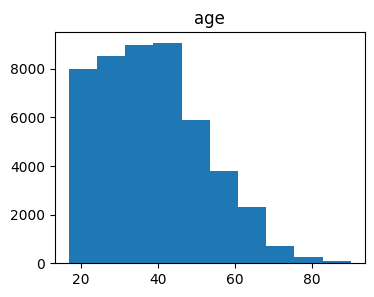

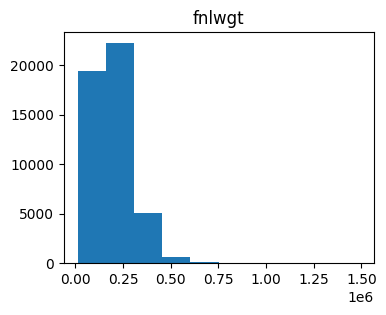

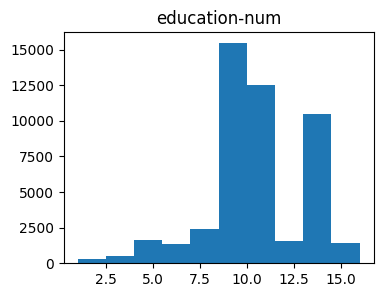

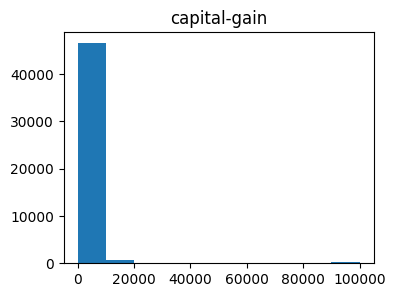

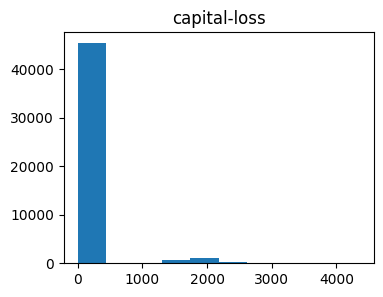

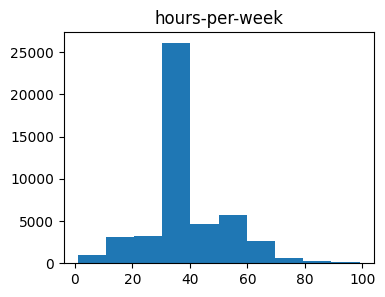

In [177]:
for col in df_adult.columns:
    if len(df_adult[col].drop_duplicates())>2:
        plt.figure(figsize=(4, 3))
        plt.hist(df_adult[col])
        plt.title(col)
        plt.show()

In [178]:
matrix = df_adult.corr()

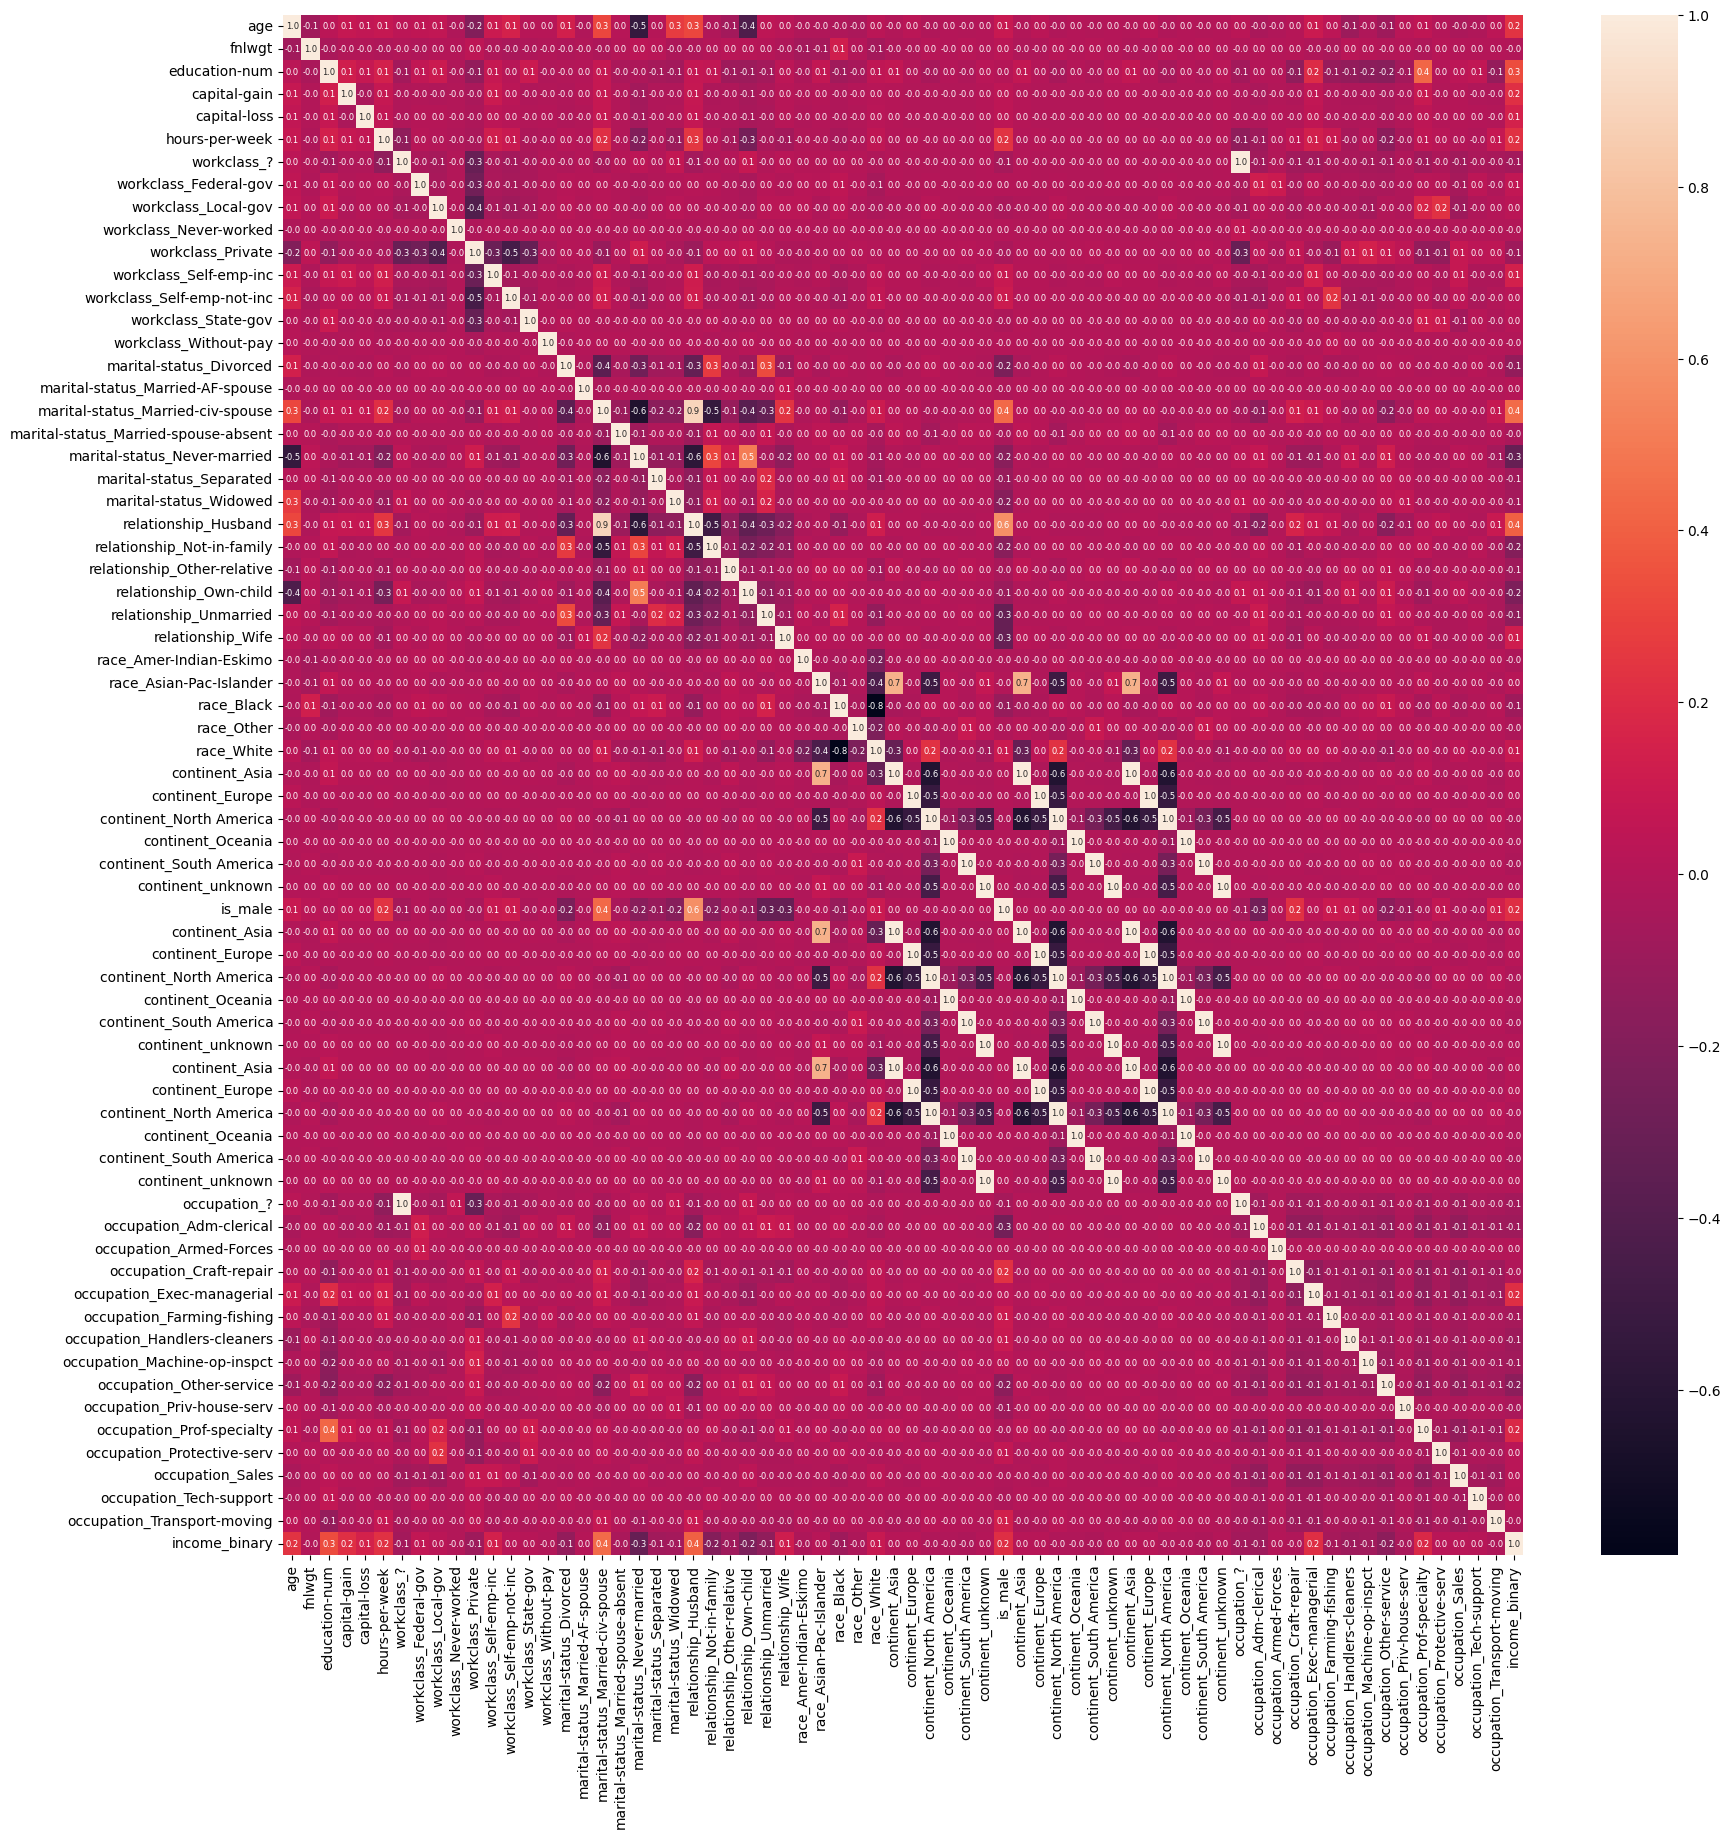

In [184]:
plt.figure(figsize=(20, 20))
sns.heatmap(matrix, xticklabels=matrix.columns.values, yticklabels=matrix.columns.values, annot=True, fmt='.1f', annot_kws={"size":6});
plt.show()

### 5. Budowa modeli
Stworzenie min. 3 modeli i tuning hiperparametrów do zadania klasyfikacji lub regresji

### 6. Ocena i wybór najlepszego modelu
Graficzna i opisowa ocena oraz wybór modelu

### 7. Podsumowanie
Podsumowanie wyników, dyskusja na temat napotkanych problemów, wyzwań i zastosowanych rozwiązań